![Banner](./../0-Course-info/images/bannerSoB.png)

# Detecting of water pollution using anomalies

**Author: Suhyb Salama, ITC**  


## Purpose 
This exercise integrates the knowledge and skills gained in the previous weeks to detect water pollution. In this exercise you will estimate water quality indices from Sentinel-2 MSI (S2-MSI) level 2A images and employ  the estimated time series (of indices) to estimate pollution incident (e.g. illegal dumping of waste or outfall of wastewater pipes). This is a python script in [jupyter notebook](https://jupyter.org/) and follows from the exercises presented in proceeding weeks.


## Prerequisites
- You should have an account in Google Earth Engine. If not done yet please [sign up now](https://earthengine.google.com/signup/).
- You should have worked out the [previous exercise 2.1](./2.1_WQ_IndicesS2.ipynb).

## What you will learn
1. Apply different indices for assessing water quality;  
2. Perform temporal and spatial aggregation;
3. Estimate the anomalies of water quality indices in time and space;
4. Analyze time series of anomalies on spatially aggregated results;
4. Visualize the results as maps and time series. 

## What will you achieve
At the end of this exercise you will be able to use Google Earth Engine to access satellite data, assess water quality using band ratios and indices from S2-MSI and detect water pollution using temporal and spatial anomalies.



## Introduction 
**Water pollution is defined as anomalies in space, or/and time of water quality indices.**


### Start 
Load the required libraries and authenticate your Google account

In [1]:
# import Google earth engine module
import ee
import geemap
import geemap.colormaps as cm
Map =geemap.Map()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**If you are not authenticated (logged in Google Earth) then you should acquire the authentication code, otherwise you can skip this cell**

In [2]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

## Data access  
Request Google Earth Engine to access [Sentinel 2 data Level-2A data](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED). Level 2 means that these images are atmospherically corrected. To have a better understanding of data level of S2-MSI you can consult the [user guide of S2-MSI](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/processing-levels).

In [4]:
s2_boa_col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

### Inquire the band names of S2-MSI image collection
- Select one image (the first);
- Inquire the bands names of this image and print.



In [5]:
first_image = s2_boa_col.first()
Bname = first_image.get('system:band_names')
print('system:band_names', Bname.getInfo())

system:band_names ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


## Filter the S2-MSI image collection to:
- area of interest *AOI*
- time period *s_date* and *e_date*
- cloud percentage *cld_per* and probability *cld_prb*

In [6]:
aoi = ee.Geometry.Polygon([
    [-2.940, 54.381],
    [-2.940, 54.369],
    [-2.927, 54.369],
    [-2.927, 54.381],
    [-2.940, 54.381]])
sY=2018
sM=1
sD=1
eY=2021
eM=12
eD =31

s_date = ee.Date.fromYMD(sY, sM, sD)
e_date   = ee.Date.fromYMD(eY, eM, eD)

cld_per = 20


* Apply the filter on the [Sentinel-2 surface reflectance](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) 

In [7]:
# filter s2-MSI bottom of atmosphere
s2_boa_flt = s2_boa_col\
    .filterBounds(aoi)\
    .filterDate(s_date, e_date)\
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cld_per))

In [8]:
count = s2_boa_flt.size()
valCount=count.getInfo()
print('Numbre of images is : ', str(valCount)+'\n')

Numbre of images is :  148



## Remove clouds and cirrus


In [10]:
def s2_cloud_mask(image):
    quality_band = image.select('QA60')
    
    # using the bit mask for clouds and cirrus clouds respectively
     # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    
    # we only want clear skies
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    
    # we'll divide by 10000 to make interpreting the reflectance values easier
    return image.updateMask(mask).divide(10000).copyProperties(image, ["system:time_start"])

## Generate a cloud-free composite
- Apply the cloud and shadow mask function **mask_cloud_shadow**

In [11]:
s2_boa_cloudfree = s2_boa_flt.map(s2_cloud_mask)

- Reduce the image collection to to show the mean or median


In [12]:
means2_sr = s2_boa_cloudfree.reduce(ee.Reducer.mean())


- Inquire the bands' names after the **reduce** operation

In [13]:
Bname = means2_sr.get('system:band_names')
Bnames =  Bname.getInfo()
print(Bnames)

['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B9_mean', 'B11_mean', 'B12_mean', 'AOT_mean', 'WVP_mean', 'SCL_mean', 'TCI_R_mean', 'TCI_G_mean', 'TCI_B_mean', 'MSK_CLDPRB_mean', 'MSK_SNWPRB_mean', 'QA10_mean', 'QA20_mean', 'QA60_mean']


In [14]:
#s2_boa_flt.first().getInfo()
#s2_boa_cloudfree.first().getInfo()

- Display the mean/median in  **GEEMAP** using bands 2, 3 and 5

In [15]:
rgbVis = {
    'min':0.0,
    'max':0.1,
    'bands':[Bnames[4],Bnames[2],Bnames[1]],
}

In [16]:
Map.addLayer(means2_sr, rgbVis, 'SAms2',1)
#show the map
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# Generate water quality indices

## Normalized difference turbidity index (NDTI)

In [17]:
def get_ndti(img):
    date = ee.Date(img.get('system:time_start'))
    ndti = img.normalizedDifference(['B3', 'B4']).rename('ndti').copyProperties(img, ["system:time_start"])
    return ndti.set({
        'system:band_names': 'ndti',
        'day' : date.get('day'),
        'year': date.get('year'),
        'month': date.get('month')})

In [19]:
ndti=s2_boa_cloudfree.map(get_ndti)
ndti.first().getInfo()

{'type': 'Image',
 'bands': [{'id': 'ndti',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32630',
   'crs_transform': [10, 0, 399960, 0, -10, 6100020]}],
 'properties': {'system:index': '20180108T113439_20180108T113443_T30UVF',
  'system:time_start': 1515411283675,
  'month': 1,
  'year': 2018,
  'day': 8}}

In [20]:
val= cm.palettes.Spectral
palette=val.default

Vis = {
  'min': -1,
  'max': 1,
  'palette': palette}
zoom_scale = 12
u_lon= -2.93
u_lat =54.37
# establish a geometry feature from the point and the scale and center the map to it
geometry = ee.Geometry.Point(u_lon,u_lat)


Map.centerObject(geometry,zoom_scale)
Map.addLayer(ndti.first(), Vis, 'ndti')

Map

Map(bottom=10703.0, center=[54.37, -2.93], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [21]:
count = ndti.size()
valCount=count.getInfo()
print('Numbre of images is : ', str(valCount)+'\n')

Numbre of images is :  148



## Calculate standardized anomalies
Anomalies are defined as the deviation from the mean value.  
$$\overline{x_i}=x_i-\mu$$

This mean value ($\mu$) could be: monthly climatology, monthly or yearly mean. The standardization can be performed by dividing the anomalies by the value of the standard deviation of the same group that was used to compute the mean (e.g. month or year). 
$$\widehat{x_i} =\frac{x_i-\mu}{\sigma}$$

Example, in case the mean is calculated from the monthly climatology, the standard deviation should also be calculated for the monthly climatology, e.g the mean and standard deviation of all Januaries in *n* years of observation:

$$\widehat{x_{jan_i}} =\frac{x_{jan_i}-\mu_{jan}}{\sigma_{jan}}$$
Where $x_{jan_i}$ is the mean value of a biophysical variable $x$ in the month January of the $i^{th}$ year of observation; $\mu_{jan}$ and $\sigma_{jan}$ are the mean and standard deviation of all Januaries over the *n* years of observation. In this case the data of $x_i$ should be organized as monthly mean (the mean over all days in a month).  We can compute the standardized anomalies with respect to various references, e.g. daily, monthly,  yearly or decadal. This largely depends on the feature/phenomenon that needs to be captured.


## Utility of standardized anomalies
Standardized anomalies provide a straightforward means to identify pollution and classify the status of water quality, as shown in [Fig.1](#Anom)

![Anom](./../0-Course-info/images/Anomalies.jpg)***Fig.1**: interpretation of indices based on standardized anomalies using turbidity as an example.*


## Time aggregation

### Compute the monthly mean of NDTI

In [24]:
myears=range(sY,eY+1)
mmonths=range(1,12+1)
years = ee.List.sequence(sY, eY)
months = ee.List.sequence(sM, eM)

In [25]:
def getMonthlyMean(iy):
    def createMean(im):
        sDate = ee.Date.fromYMD(iy, im, sD)
        eDate = sDate.advance(1, 'month')
        monthFiltered = ndti.filter(ee.Filter.date(sDate, eDate))
        msum = monthFiltered.reduce(ee.Reducer.mean())
        return msum.set({
            'system:time_start': sDate.millis(),
            'system:time_end': eDate.millis(),
            'year': iy,
            'month': im,
            'date': sDate.millis()})
    return months.map(createMean)

In [26]:
monthlyNDTI= ee.ImageCollection.fromImages(years.map(getMonthlyMean).flatten())

In [27]:
count = monthlyNDTI.size()
valCount=count.getInfo()
print('Numbre of monthly mean images is : ', str(valCount)+'\n')

Numbre of monthly mean images is :  48



### Clean the results
1. Due to the applied filet of cloud percentage, some months could have no images 
2. These empty images should be removed from the image collection using the function **addSize** and the **filterMetadata**. 
3. The function **addSize** will add the number of bands of each image (in this case each image contain one band) as a meta data property 
4. Then you can use **filterMetadata** to filter those images that have a band   

*there is anther way to do so, maybe you would like to find it out!*

In [28]:
def addSize(img):
    n = img.bandNames().size()
    return img.set({'n': n})
monthlyNDTI = monthlyNDTI.map(addSize).filterMetadata('n', 'equals', 1)

In [29]:
count = monthlyNDTI.size()
valCount=count.getInfo()
print('Numbre of monthly mean images is : ', str(valCount)+'\n')

first_image = monthlyNDTI.first()

Map.centerObject(geometry,zoom_scale)

iname=ee.Date(first_image.get('system:time_start')).format("yyyy-MM-dd")

Map.addLayer(first_image, Vis, iname.getInfo())
Map

Numbre of monthly mean images is :  43



Map(bottom=335137.0, center=[54.37, -2.93], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

### Compute the monthly climatology
**Monthly climatology** is the the mean/std of a month over all years of observations.
1. Compute the monthly climatology mean using the function **getMonthlyClimatology_mean**
2. Compute the monthly climatology standard deviation using the function **getMonthlyClimatology_std**  

**It is useful to check the results of each calculation!**


In [30]:
def getMonthlyClimatology_mean(mm):
    img =  monthlyNDTI.filter(ee.Filter.calendarRange(sY,eY , 'year')).filter(ee.Filter.calendarRange(mm, mm, 'month'))
    msum = img.reduce(ee.Reducer.mean())
    timeStamp = ee.Date.fromYMD(sY,mm,1)
    return msum.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': sY,
        'month': mm,
        'date': timeStamp.millis()})

In [31]:
MonthlyClim_mean= ee.ImageCollection.fromImages(months.map(getMonthlyClimatology_mean).flatten()) 
count = MonthlyClim_mean.size()
valCount=count.getInfo()
print('Number of monthly Climatlogy images is : ', str(valCount)+'\n')

Number of monthly Climatlogy images is :  12



In [32]:
def getMonthlyClimatology_std(mm):
    img =  monthlyNDTI.filter(ee.Filter.calendarRange(sY,eY , 'year')).filter(ee.Filter.calendarRange(mm, mm, 'month'))
    msum = img.reduce(ee.Reducer.stdDev())
    timeStamp = ee.Date.fromYMD(sY,mm,1)
    return msum.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': sY,
        'month': mm,
        'date': timeStamp.millis()})

In [33]:
MonthlyClim_std= ee.ImageCollection.fromImages(months.map(getMonthlyClimatology_mean).flatten()) 

In [34]:
count = MonthlyClim_std.size()
valCount=count.getInfo()
print('Number of monthly Climatlogy images STD is : ', str(valCount)+'\n')

Number of monthly Climatlogy images STD is :  12



In [35]:
first_image = MonthlyClim_std.first()

Map.centerObject(geometry,zoom_scale)
Vis = {
  'min': 0,
  'max': 10,
  'palette': palette}

Map.addLayer(first_image, Vis, 'std')
Map

Map(bottom=335137.0, center=[54.37, -2.93], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

### Compute the standardized anomalies 
1. In this example you will calculate the standardized anomalies of monthly mean and using the monthly climatology (mean/std) estimated in the previous step 
2. The function **getStand_Anom** will take a sequence of months from 1-12 and iterate to:
    2.1. select the corresponding image monthly mean
    2.2. select the corresponding climatology mean and std
    2.3. compute the standardize anomalies using the function **computeAnom**

In [37]:
def getStand_Anom(mm):
    
    imgcol  =  monthlyNDTI.filter(ee.Filter.calendarRange(sY,eY , 'year')).filter(ee.Filter.calendarRange(mm, mm, 'month'))
    mimg_col =  MonthlyClim_mean.filter(ee.Filter.calendarRange(mm, mm, 'month'))
    mimg = mimg_col.first().select(0)
    
    simg_col =  MonthlyClim_std.filter(ee.Filter.calendarRange(mm, mm, 'month'))
    simg = simg_col.first().select(0)

    def computeAnom(img):
        timeStamp =  ee.Date(img.get('system:time_start'))
        year= timeStamp.get('year')
        month= timeStamp.get('month')
        day= timeStamp.get('day')
        
        band=img.select(0)
        A    = band.subtract(mimg)
        Anom = A.divide(simg).rename('Anom').copyProperties(img, ["system:time_start"])
        
        Anom.set({
            'system:time_start': timeStamp,
            'year': year,
            'month': month,
            'day': day,            
            'date': timeStamp})
        return Anom
    return imgcol.map(computeAnom)

In [39]:
MonthlyAnom = ee.ImageCollection( # Cast result to ImageCollection
  ee.FeatureCollection( # Create an intermediate FeatureCollection containing ImageCollections
    months.map(getStand_Anom)
  ).flatten() # Remove the intermediate feature collection with the merged image collections
)

In [40]:
count = MonthlyAnom.size()
valCount=count.getInfo()
print('Number of MonthlyAnom is : ', str(valCount)+'\n')

Number of MonthlyAnom is :  43



In [41]:
first_image = MonthlyAnom.first()
Vis = {
  'min': -3,
  'max': 3,
  'palette': palette}
Map.centerObject(geometry,zoom_scale)

iname=ee.Date(first_image.get('system:time_start')).format("yyyy-MM-dd")

Map.addLayer(first_image, Vis, iname.getInfo())
Map

Map(bottom=335137.0, center=[54.37, -2.93], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

## Time series extraction 
To work with a time series you can extract a point or a region. Here we will extract the time series of a box in the .
To be able to do so the following steps are needed
1. Select the region of interest (ROI);
2. Clip the image to the ROI and average over the region;
3. Extract the time series of the areal average;




###  Select the region of interest
- Select the lake region
- There are a couple ways:  
      - You can easily create a geojson file using the [interactive geojson map](https://geojson.io/)  
      - Or define it as a box inside the Lake.

* Add the polygon to the map to see if you have the bounds correct

In [42]:
Map.setCenter(-2.94, 54.381);
Map.addLayer(aoi.bounds(),
             {'color': 'red'},
             'Result [red]: polygon.bounds')


- The function **getTM4RoI** will iterate on the images in an image collection and use the nested function **iter_func** to extract the date and calculate the mean of a region using **.reduceRegion.** The function will return these values as a list of two columns ['Dates', 'NDTI'].

In [43]:
def getTM4RoI(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"))
        stat= image.reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry = aoi,
            scale = 5000,
            maxPixels=1e15)
        newlist = ee.List(newlist)
        return ee.List(newlist.add([date, stat]))
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).getInfo())

### Convert to a Data Frame
The function **Convert2TM_DF** will take the generated list from **getTM4RoI** and convert to a *Pandas Data frame* with recognizable dates. This step will make time series analysis much easier. *Pandas Data frame* is a python library and is outside GEE.

In [44]:
def Convert2TM_DF(inList):
    newList =[]
    for i, item in enumerate(inList):
        val0=item[1].values()
        if np.any(val0):
            val=list(val0)
            newList.append([item[0],val[0]])
    DF=pd.DataFrame(newList,columns=['Dates' ,'NDTI'])
    datetime_series = pd.to_datetime(DF['Dates'],format='%Y%m%d')
    DF.drop('Dates', axis=1, inplace=True)
    DF.set_index(datetime_series, inplace=True,drop=True)
    DF.mask(DF.eq('None')).dropna()
    return DF

#### Extract various time series
To do so, apply the function **getTM4RoI** first and then use its output in the function **Convert2TM_DF**
Or you can do it in one run *res=Convert2TM_DF(getTM4RoI(ImgCol,Name))* as shown in later examples.

- Extract three time series:
    - NDTI  
    - monthly mean *monthlyNDTI*
    - monthly climatology  *MonthlyClim*
    

In [45]:
TM_NDTI  = Convert2TM_DF(getTM4RoI(ndti))
TM_NDTI_m  = Convert2TM_DF(getTM4RoI(monthlyNDTI))
TM_NDTI_mC  = Convert2TM_DF(getTM4RoI(MonthlyClim_mean))


- Plot the monthly values

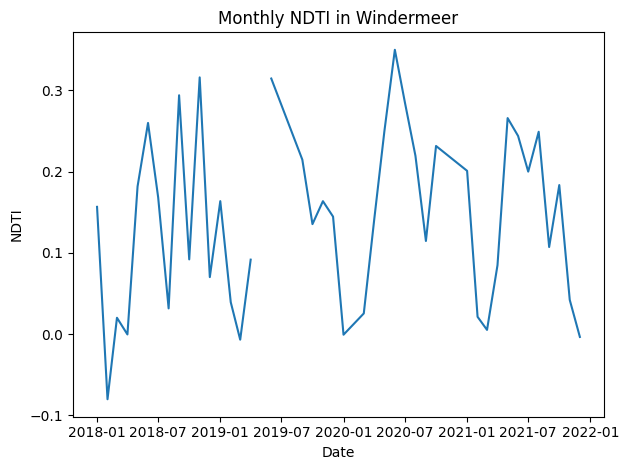

In [46]:
plt.plot(TM_NDTI_m.index, TM_NDTI_m.NDTI)
plt.xlabel("Date")
plt.ylabel("NDTI")
plt.title("Monthly NDTI in Windermeer")
plt.tight_layout()


## Calculate the anomalies on PANDAS data frame
 - In this section you will learn to compute the anomalies on the time series of the data frame in PANDAS.  
 - In comparison to GEE, you will notice how easy it is to perform the same operation in PNADAS.  
 

In [47]:
 Anom =TM_NDTI_m.groupby(TM_NDTI_m.index.month).transform(lambda x: (x-x.mean())/x.std())

* Compare with  the anomalies extracted from the image

In [48]:
TM_Anom=  Convert2TM_DF(getTM4RoI(MonthlyAnom))

- Print the Data Frame of *TM_Anom*
- Note the order of the time series.

In [49]:
TM_Anom

,NDTI
Dates,
2018-01-01,0.203685
2019-01-01,0.257611
2020-01-01,-1.005543
2021-01-01,0.544247
2018-02-01,11.297956
2019-02-01,-7.026478
2021-02-01,-4.271478
2018-03-01,0.831164
2019-03-01,-1.621851


* Sort the Date Frame so it is ascended according to time 
* Plot both Anomalies time series

In [51]:
TM_Anom.sort_values(by="Dates", inplace = True)

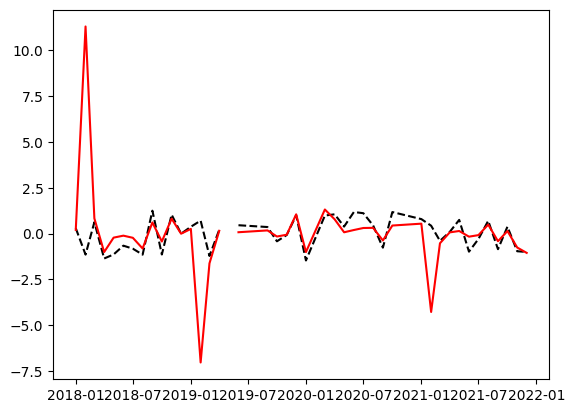

In [52]:
plt.plot(Anom.index, Anom.NDTI,color = 'k', linestyle = '--')
plt.plot(TM_Anom.index, TM_Anom.NDTI,color = 'r', linestyle = '-')


- Can you explain the differences? 

- We can smooth the results by using a moving average  
- The example below uses three months window  

In [53]:
Anom_smooth=Anom.rolling(window=3).mean()

 ## Visualize
 1. Here we will using the python library [Matplotlib] (https://matplotlib.org/).  
 2. After plotting the anomalies, define a threshold values for highly turbid water, *say +0.3* and very clear water, *say -0.3*.  
 3. Shade the areas to identify turbidity events.   
    

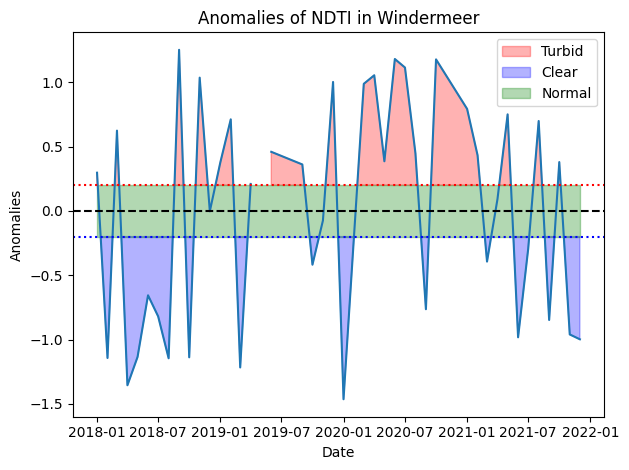

In [216]:
X=Anom.index
Y=Anom.NDTI
plt.plot(X, Y)
plt.xlabel("Date")
plt.ylabel("Anomalies")
plt.title("Anomalies of NDTI in Windermeer")
plt.tight_layout()
turbid=0.2
clear=-0.2
plt.axhline(y = 0, color = 'k', linestyle = '--')

plt.axhline(y = turbid, color = 'r', linestyle = ':')

plt.axhline(y = clear, color = 'b', linestyle = ':')

plt.fill_between(X,Y, turbid,
                 where=(Y >= turbid),
                 alpha=0.30, color='red', interpolate=True,label='Turbid')
plt.fill_between(X, Y, clear,
                 where=(Y <= clear),
                 alpha=0.30, color='blue', interpolate=True,label='Clear')

plt.fill_between(X, clear, turbid, alpha=0.30, color='green',label='Normal')

plt.legend()

## End of exercise